#Import the libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
import sys
import math
import random
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset, ConcatDataset
import random
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preparation

In [ ]:
# this cell is regarding the aumentation and normalization with the stats of data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2)),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/training_set", transform= transform_train)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/test_set", transform= transform_test)

In [ ]:
# create a bar plot
def get_class_distribution(dataset_obj):
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

train_dist = get_class_distribution(train_dataset)

courses = list(train_dist.keys())
values = list(train_dist.values())
colors = ['b', 'r']

fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values, color =colors, width = 0.4)

In [ ]:
# this cell is spliting train to train and val
total_size = len(train_dataset)
val_split = 0.2
val_size = int(val_split * total_size)
train_size = len(train_dataset) - val_size
# train_size = train_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


# Define the data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          drop_last=True)
val_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128,
                         drop_last=True)

#Finetune resnet 18

In [ ]:
# Define the ResNet18 model
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()

            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of the network on the train images after 1 epochs is: 55.640625
Accuracy of the network on the val images after 1 epochs is: 52.3125


  2%|▏         | 1/50 [02:08<1:45:09, 128.77s/it]

Accuracy of the network on the test images after 1 epochs is: 49.479166666666664
------------------------
Accuracy of the network on the train images after 2 epochs is: 58.21875
Accuracy of the network on the val images after 2 epochs is: 63.15625


  4%|▍         | 2/50 [04:15<1:42:06, 127.64s/it]

Accuracy of the network on the test images after 2 epochs is: 61.458333333333336
------------------------
Accuracy of the network on the train images after 3 epochs is: 60.78125
Accuracy of the network on the val images after 3 epochs is: 55.046875


  6%|▌         | 3/50 [06:21<1:39:30, 127.03s/it]

Accuracy of the network on the test images after 3 epochs is: 53.177083333333336
------------------------
Accuracy of the network on the train images after 4 epochs is: 64.890625
Accuracy of the network on the val images after 4 epochs is: 59.421875


  8%|▊         | 4/50 [08:28<1:37:23, 127.03s/it]

Accuracy of the network on the test images after 4 epochs is: 56.458333333333336
------------------------
Accuracy of the network on the train images after 5 epochs is: 67.046875
Accuracy of the network on the val images after 5 epochs is: 67.046875


 10%|█         | 5/50 [10:35<1:35:04, 126.78s/it]

Accuracy of the network on the test images after 5 epochs is: 65.26041666666667
------------------------
Accuracy of the network on the train images after 6 epochs is: 67.03125
Accuracy of the network on the val images after 6 epochs is: 69.71875


 12%|█▏        | 6/50 [12:42<1:33:09, 127.02s/it]

Accuracy of the network on the test images after 6 epochs is: 69.47916666666667
------------------------
Accuracy of the network on the train images after 7 epochs is: 71.078125
Accuracy of the network on the val images after 7 epochs is: 62.234375


 14%|█▍        | 7/50 [14:49<1:30:59, 126.96s/it]

Accuracy of the network on the test images after 7 epochs is: 63.229166666666664
------------------------
Accuracy of the network on the train images after 8 epochs is: 70.125
Accuracy of the network on the val images after 8 epochs is: 68.03125


 16%|█▌        | 8/50 [16:56<1:28:47, 126.84s/it]

Accuracy of the network on the test images after 8 epochs is: 65.625
------------------------
Accuracy of the network on the train images after 9 epochs is: 70.34375
Accuracy of the network on the val images after 9 epochs is: 66.734375


 18%|█▊        | 9/50 [19:03<1:26:41, 126.86s/it]

Accuracy of the network on the test images after 9 epochs is: 65.20833333333333
------------------------
Accuracy of the network on the train images after 10 epochs is: 73.15625
Accuracy of the network on the val images after 10 epochs is: 72.375


 20%|██        | 10/50 [21:09<1:24:27, 126.68s/it]

Accuracy of the network on the test images after 10 epochs is: 72.39583333333333
------------------------
Accuracy of the network on the train images after 11 epochs is: 74.25
Accuracy of the network on the val images after 11 epochs is: 73.421875


 22%|██▏       | 11/50 [23:15<1:22:08, 126.36s/it]

Accuracy of the network on the test images after 11 epochs is: 72.39583333333333
------------------------
Accuracy of the network on the train images after 12 epochs is: 75.125
Accuracy of the network on the val images after 12 epochs is: 77.546875


 24%|██▍       | 12/50 [25:21<1:19:59, 126.29s/it]

Accuracy of the network on the test images after 12 epochs is: 75.3125
------------------------
Accuracy of the network on the train images after 13 epochs is: 75.046875
Accuracy of the network on the val images after 13 epochs is: 69.640625


 26%|██▌       | 13/50 [27:27<1:17:54, 126.35s/it]

Accuracy of the network on the test images after 13 epochs is: 68.33333333333333
------------------------
Accuracy of the network on the train images after 14 epochs is: 75.0
Accuracy of the network on the val images after 14 epochs is: 63.515625


 28%|██▊       | 14/50 [29:33<1:15:44, 126.25s/it]

Accuracy of the network on the test images after 14 epochs is: 64.79166666666667
------------------------
Accuracy of the network on the train images after 15 epochs is: 76.484375
Accuracy of the network on the val images after 15 epochs is: 70.328125


 30%|███       | 15/50 [31:41<1:13:52, 126.64s/it]

Accuracy of the network on the test images after 15 epochs is: 70.625
------------------------
Accuracy of the network on the train images after 16 epochs is: 77.578125
Accuracy of the network on the val images after 16 epochs is: 67.828125


 32%|███▏      | 16/50 [33:47<1:11:43, 126.59s/it]

Accuracy of the network on the test images after 16 epochs is: 69.01041666666667
------------------------
Accuracy of the network on the train images after 17 epochs is: 77.1875
Accuracy of the network on the val images after 17 epochs is: 67.25


 34%|███▍      | 17/50 [35:54<1:09:42, 126.74s/it]

Accuracy of the network on the test images after 17 epochs is: 68.75
------------------------
Accuracy of the network on the train images after 18 epochs is: 77.6875
Accuracy of the network on the val images after 18 epochs is: 78.9375


 36%|███▌      | 18/50 [38:01<1:07:34, 126.70s/it]

Accuracy of the network on the test images after 18 epochs is: 79.47916666666667
------------------------
Accuracy of the network on the train images after 19 epochs is: 78.5625
Accuracy of the network on the val images after 19 epochs is: 72.609375


 38%|███▊      | 19/50 [40:07<1:05:18, 126.42s/it]

Accuracy of the network on the test images after 19 epochs is: 73.38541666666667
------------------------
Accuracy of the network on the train images after 20 epochs is: 78.546875
Accuracy of the network on the val images after 20 epochs is: 79.9375


 40%|████      | 20/50 [42:14<1:03:22, 126.75s/it]

Accuracy of the network on the test images after 20 epochs is: 79.01041666666667
------------------------
Accuracy of the network on the train images after 21 epochs is: 79.703125
Accuracy of the network on the val images after 21 epochs is: 64.578125


 42%|████▏     | 21/50 [44:20<1:01:09, 126.53s/it]

Accuracy of the network on the test images after 21 epochs is: 62.864583333333336
------------------------
Accuracy of the network on the train images after 22 epochs is: 79.9375
Accuracy of the network on the val images after 22 epochs is: 80.203125


 44%|████▍     | 22/50 [46:26<58:58, 126.38s/it]  

Accuracy of the network on the test images after 22 epochs is: 78.07291666666667
------------------------
Accuracy of the network on the train images after 23 epochs is: 79.625
Accuracy of the network on the val images after 23 epochs is: 75.828125


 46%|████▌     | 23/50 [48:33<56:58, 126.62s/it]

Accuracy of the network on the test images after 23 epochs is: 74.89583333333333
------------------------
Accuracy of the network on the train images after 24 epochs is: 80.125
Accuracy of the network on the val images after 24 epochs is: 79.984375


 48%|████▊     | 24/50 [50:39<54:46, 126.39s/it]

Accuracy of the network on the test images after 24 epochs is: 78.59375
------------------------
Accuracy of the network on the train images after 25 epochs is: 80.578125
Accuracy of the network on the val images after 25 epochs is: 80.5625


 50%|█████     | 25/50 [52:46<52:41, 126.48s/it]

Accuracy of the network on the test images after 25 epochs is: 79.27083333333333
------------------------
Accuracy of the network on the train images after 26 epochs is: 81.21875
Accuracy of the network on the val images after 26 epochs is: 76.546875


 52%|█████▏    | 26/50 [54:52<50:35, 126.46s/it]

Accuracy of the network on the test images after 26 epochs is: 75.10416666666667
------------------------
Accuracy of the network on the train images after 27 epochs is: 82.46875
Accuracy of the network on the val images after 27 epochs is: 82.875


 54%|█████▍    | 27/50 [56:56<48:07, 125.56s/it]

Accuracy of the network on the test images after 27 epochs is: 82.1875
------------------------
Accuracy of the network on the train images after 28 epochs is: 82.609375
Accuracy of the network on the val images after 28 epochs is: 71.71875


 56%|█████▌    | 28/50 [59:00<45:53, 125.14s/it]

Accuracy of the network on the test images after 28 epochs is: 71.66666666666667
------------------------
Accuracy of the network on the train images after 29 epochs is: 81.890625
Accuracy of the network on the val images after 29 epochs is: 83.5625


 58%|█████▊    | 29/50 [1:01:04<43:40, 124.77s/it]

Accuracy of the network on the test images after 29 epochs is: 83.38541666666667
------------------------
Accuracy of the network on the train images after 30 epochs is: 83.875
Accuracy of the network on the val images after 30 epochs is: 80.28125


 60%|██████    | 30/50 [1:03:07<41:26, 124.30s/it]

Accuracy of the network on the test images after 30 epochs is: 78.07291666666667
------------------------
Accuracy of the network on the train images after 31 epochs is: 83.109375
Accuracy of the network on the val images after 31 epochs is: 80.59375


 62%|██████▏   | 31/50 [1:05:10<39:16, 124.04s/it]

Accuracy of the network on the test images after 31 epochs is: 78.75
------------------------
Accuracy of the network on the train images after 32 epochs is: 83.796875
Accuracy of the network on the val images after 32 epochs is: 80.25


 64%|██████▍   | 32/50 [1:07:14<37:09, 123.84s/it]

Accuracy of the network on the test images after 32 epochs is: 78.28125
------------------------
Accuracy of the network on the train images after 33 epochs is: 83.328125
Accuracy of the network on the val images after 33 epochs is: 82.671875


 66%|██████▌   | 33/50 [1:09:17<35:00, 123.58s/it]

Accuracy of the network on the test images after 33 epochs is: 82.65625
------------------------
Accuracy of the network on the train images after 34 epochs is: 83.890625
Accuracy of the network on the val images after 34 epochs is: 80.90625


 68%|██████▊   | 34/50 [1:11:20<32:57, 123.57s/it]

Accuracy of the network on the test images after 34 epochs is: 79.53125
------------------------
Accuracy of the network on the train images after 35 epochs is: 84.09375
Accuracy of the network on the val images after 35 epochs is: 75.890625


 70%|███████   | 35/50 [1:13:24<30:54, 123.64s/it]

Accuracy of the network on the test images after 35 epochs is: 75.3125
------------------------
Accuracy of the network on the train images after 36 epochs is: 84.828125
Accuracy of the network on the val images after 36 epochs is: 83.90625


 72%|███████▏  | 36/50 [1:15:28<28:50, 123.60s/it]

Accuracy of the network on the test images after 36 epochs is: 82.55208333333333
------------------------
Accuracy of the network on the train images after 37 epochs is: 84.90625
Accuracy of the network on the val images after 37 epochs is: 84.171875


 74%|███████▍  | 37/50 [1:17:32<26:48, 123.73s/it]

Accuracy of the network on the test images after 37 epochs is: 83.4375
------------------------
Accuracy of the network on the train images after 38 epochs is: 85.453125
Accuracy of the network on the val images after 38 epochs is: 86.03125


 76%|███████▌  | 38/50 [1:19:37<24:48, 124.05s/it]

Accuracy of the network on the test images after 38 epochs is: 84.63541666666667
------------------------
Accuracy of the network on the train images after 39 epochs is: 85.078125
Accuracy of the network on the val images after 39 epochs is: 78.875


 78%|███████▊  | 39/50 [1:21:41<22:44, 124.05s/it]

Accuracy of the network on the test images after 39 epochs is: 79.42708333333333
------------------------
Accuracy of the network on the train images after 40 epochs is: 85.859375
Accuracy of the network on the val images after 40 epochs is: 85.078125


 80%|████████  | 40/50 [1:23:45<20:40, 124.04s/it]

Accuracy of the network on the test images after 40 epochs is: 83.125
------------------------
Accuracy of the network on the train images after 41 epochs is: 86.03125
Accuracy of the network on the val images after 41 epochs is: 84.9375


 82%|████████▏ | 41/50 [1:25:50<18:39, 124.42s/it]

Accuracy of the network on the test images after 41 epochs is: 83.28125
------------------------
Accuracy of the network on the train images after 42 epochs is: 86.109375
Accuracy of the network on the val images after 42 epochs is: 85.21875


 84%|████████▍ | 42/50 [1:27:55<16:36, 124.62s/it]

Accuracy of the network on the test images after 42 epochs is: 84.6875
------------------------
Accuracy of the network on the train images after 43 epochs is: 86.421875
Accuracy of the network on the val images after 43 epochs is: 85.8125


 86%|████████▌ | 43/50 [1:29:59<14:31, 124.55s/it]

Accuracy of the network on the test images after 43 epochs is: 84.21875
------------------------
Accuracy of the network on the train images after 44 epochs is: 86.9375
Accuracy of the network on the val images after 44 epochs is: 86.8125


 88%|████████▊ | 44/50 [1:32:05<12:29, 124.97s/it]

Accuracy of the network on the test images after 44 epochs is: 84.16666666666667
------------------------
Accuracy of the network on the train images after 45 epochs is: 86.4375
Accuracy of the network on the val images after 45 epochs is: 79.46875


 90%|█████████ | 45/50 [1:34:12<10:26, 125.33s/it]

Accuracy of the network on the test images after 45 epochs is: 77.13541666666667
------------------------
Accuracy of the network on the train images after 46 epochs is: 87.25
Accuracy of the network on the val images after 46 epochs is: 85.8125


 92%|█████████▏| 46/50 [1:36:17<08:21, 125.35s/it]

Accuracy of the network on the test images after 46 epochs is: 84.375
------------------------
Accuracy of the network on the train images after 47 epochs is: 87.125
Accuracy of the network on the val images after 47 epochs is: 81.90625


 94%|█████████▍| 47/50 [1:38:21<06:15, 125.08s/it]

Accuracy of the network on the test images after 47 epochs is: 80.20833333333333
------------------------
Accuracy of the network on the train images after 48 epochs is: 87.078125
Accuracy of the network on the val images after 48 epochs is: 87.34375


 96%|█████████▌| 48/50 [1:40:26<04:09, 124.93s/it]

Accuracy of the network on the test images after 48 epochs is: 85.3125
------------------------
Accuracy of the network on the train images after 49 epochs is: 87.953125
Accuracy of the network on the val images after 49 epochs is: 85.875


 98%|█████████▊| 49/50 [1:42:30<02:04, 124.70s/it]

Accuracy of the network on the test images after 49 epochs is: 83.80208333333333
------------------------
Accuracy of the network on the train images after 50 epochs is: 87.421875
Accuracy of the network on the val images after 50 epochs is: 87.375


100%|██████████| 50/50 [1:44:35<00:00, 125.51s/it]

Accuracy of the network on the test images after 50 epochs is: 86.45833333333333
------------------------


In [ ]:
#save the path
model_save_name = 'resnet18.pt'
path = f"/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/{model_save_name}" 
torch.save(model.state_dict(), path)

Text(0, 0.5, 'loss')

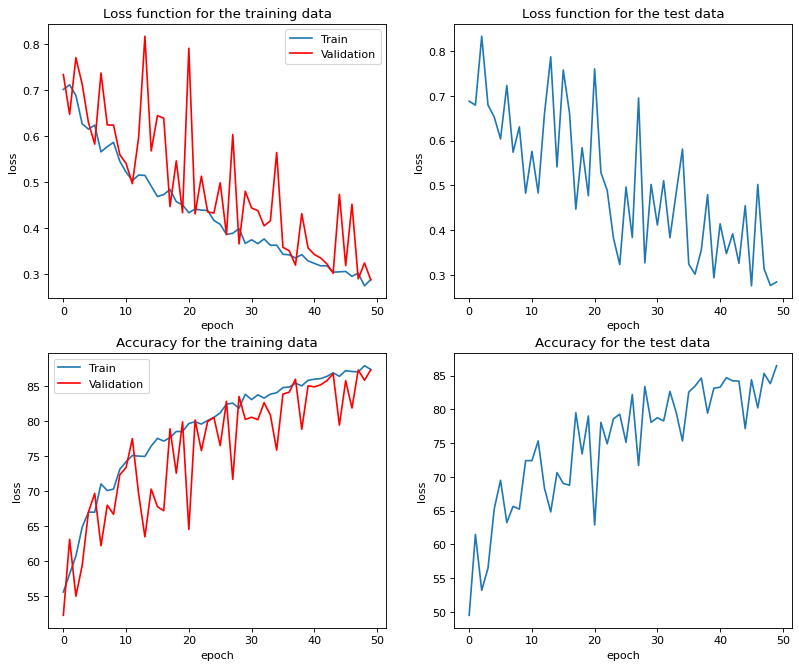

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/accuracy_resnet18.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/loss_resnet18.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

#ShuffleNetV2

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

In [ ]:
#save the path
model_save_name = 'shufflenet_v2_x1_0.pt'
path = f"/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/accuracy_shufflenet_v2_x1_0.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/loss_shufflenet_v2_x1_0.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

#MobileNetV2

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of the network on the train images after 1 epochs is: 51.46875
Accuracy of the network on the val images after 1 epochs is: 50.015625


  2%|▏         | 1/50 [27:09<22:10:23, 1629.06s/it]

Accuracy of the network on the test images after 1 epochs is: 52.708333333333336
------------------------
Accuracy of the network on the train images after 2 epochs is: 62.0
Accuracy of the network on the val images after 2 epochs is: 59.3125


  4%|▍         | 2/50 [29:25<10:01:00, 751.25s/it] 

Accuracy of the network on the test images after 2 epochs is: 61.666666666666664
------------------------
Accuracy of the network on the train images after 3 epochs is: 63.671875
Accuracy of the network on the val images after 3 epochs is: 62.015625


  6%|▌         | 3/50 [31:41<6:08:24, 470.32s/it] 

Accuracy of the network on the test images after 3 epochs is: 61.40625
------------------------
Accuracy of the network on the train images after 4 epochs is: 65.9375
Accuracy of the network on the val images after 4 epochs is: 55.859375


  8%|▊         | 4/50 [33:58<4:19:37, 338.65s/it]

Accuracy of the network on the test images after 4 epochs is: 51.979166666666664
------------------------
Accuracy of the network on the train images after 5 epochs is: 67.65625
Accuracy of the network on the val images after 5 epochs is: 53.15625


 10%|█         | 5/50 [36:16<3:19:43, 266.29s/it]

Accuracy of the network on the test images after 5 epochs is: 51.510416666666664
------------------------
Accuracy of the network on the train images after 6 epochs is: 68.984375
Accuracy of the network on the val images after 6 epochs is: 65.875


 12%|█▏        | 6/50 [38:33<2:42:56, 222.19s/it]

Accuracy of the network on the test images after 6 epochs is: 60.3125
------------------------
Accuracy of the network on the train images after 7 epochs is: 69.390625
Accuracy of the network on the val images after 7 epochs is: 65.171875


 14%|█▍        | 7/50 [40:50<2:19:22, 194.47s/it]

Accuracy of the network on the test images after 7 epochs is: 61.979166666666664
------------------------
Accuracy of the network on the train images after 8 epochs is: 70.46875
Accuracy of the network on the val images after 8 epochs is: 70.1875


 16%|█▌        | 8/50 [43:08<2:03:27, 176.36s/it]

Accuracy of the network on the test images after 8 epochs is: 70.78125
------------------------
Accuracy of the network on the train images after 9 epochs is: 71.34375
Accuracy of the network on the val images after 9 epochs is: 69.265625


 18%|█▊        | 9/50 [45:25<1:52:06, 164.07s/it]

Accuracy of the network on the test images after 9 epochs is: 68.28125
------------------------
Accuracy of the network on the train images after 10 epochs is: 71.125
Accuracy of the network on the val images after 10 epochs is: 71.875


 20%|██        | 10/50 [47:42<1:43:52, 155.81s/it]

Accuracy of the network on the test images after 10 epochs is: 71.09375
------------------------
Accuracy of the network on the train images after 11 epochs is: 73.0625
Accuracy of the network on the val images after 11 epochs is: 62.0


 22%|██▏       | 11/50 [49:59<1:37:31, 150.05s/it]

Accuracy of the network on the test images after 11 epochs is: 65.10416666666667
------------------------
Accuracy of the network on the train images after 12 epochs is: 73.078125
Accuracy of the network on the val images after 12 epochs is: 73.734375


 24%|██▍       | 12/50 [52:17<1:32:38, 146.27s/it]

Accuracy of the network on the test images after 12 epochs is: 74.84375
------------------------
Accuracy of the network on the train images after 13 epochs is: 74.609375
Accuracy of the network on the val images after 13 epochs is: 68.84375


 26%|██▌       | 13/50 [54:34<1:28:29, 143.51s/it]

Accuracy of the network on the test images after 13 epochs is: 64.53125
------------------------
Accuracy of the network on the train images after 14 epochs is: 75.03125
Accuracy of the network on the val images after 14 epochs is: 68.421875


 28%|██▊       | 14/50 [56:51<1:24:56, 141.56s/it]

Accuracy of the network on the test images after 14 epochs is: 70.57291666666667
------------------------
Accuracy of the network on the train images after 15 epochs is: 74.96875
Accuracy of the network on the val images after 15 epochs is: 73.3125


 30%|███       | 15/50 [59:08<1:21:50, 140.29s/it]

Accuracy of the network on the test images after 15 epochs is: 71.5625
------------------------
Accuracy of the network on the train images after 16 epochs is: 75.984375
Accuracy of the network on the val images after 16 epochs is: 71.21875


 32%|███▏      | 16/50 [1:01:26<1:19:05, 139.56s/it]

Accuracy of the network on the test images after 16 epochs is: 73.85416666666667
------------------------
Accuracy of the network on the train images after 17 epochs is: 76.78125
Accuracy of the network on the val images after 17 epochs is: 72.671875


 34%|███▍      | 17/50 [1:03:42<1:16:14, 138.61s/it]

Accuracy of the network on the test images after 17 epochs is: 70.9375
------------------------
Accuracy of the network on the train images after 18 epochs is: 76.390625
Accuracy of the network on the val images after 18 epochs is: 69.671875


 36%|███▌      | 18/50 [1:05:59<1:13:38, 138.06s/it]

Accuracy of the network on the test images after 18 epochs is: 63.958333333333336
------------------------
Accuracy of the network on the train images after 19 epochs is: 78.15625
Accuracy of the network on the val images after 19 epochs is: 77.71875


 38%|███▊      | 19/50 [1:08:16<1:11:05, 137.61s/it]

Accuracy of the network on the test images after 19 epochs is: 79.01041666666667
------------------------
Accuracy of the network on the train images after 20 epochs is: 78.46875
Accuracy of the network on the val images after 20 epochs is: 60.34375


 40%|████      | 20/50 [1:10:32<1:08:31, 137.06s/it]

Accuracy of the network on the test images after 20 epochs is: 55.416666666666664
------------------------
Accuracy of the network on the train images after 21 epochs is: 79.109375
Accuracy of the network on the val images after 21 epochs is: 60.3125


 42%|████▏     | 21/50 [1:12:47<1:05:58, 136.50s/it]

Accuracy of the network on the test images after 21 epochs is: 63.333333333333336
------------------------
Accuracy of the network on the train images after 22 epochs is: 79.640625
Accuracy of the network on the val images after 22 epochs is: 75.65625


 44%|████▍     | 22/50 [1:15:02<1:03:32, 136.15s/it]

Accuracy of the network on the test images after 22 epochs is: 73.95833333333333
------------------------
Accuracy of the network on the train images after 23 epochs is: 80.171875
Accuracy of the network on the val images after 23 epochs is: 73.359375


 46%|████▌     | 23/50 [1:17:18<1:01:12, 136.03s/it]

Accuracy of the network on the test images after 23 epochs is: 76.04166666666667
------------------------
Accuracy of the network on the train images after 24 epochs is: 80.171875
Accuracy of the network on the val images after 24 epochs is: 79.75


 48%|████▊     | 24/50 [1:19:34<58:57, 136.06s/it]  

Accuracy of the network on the test images after 24 epochs is: 78.07291666666667
------------------------
Accuracy of the network on the train images after 25 epochs is: 80.171875
Accuracy of the network on the val images after 25 epochs is: 72.28125


 50%|█████     | 25/50 [1:21:50<56:39, 135.99s/it]

Accuracy of the network on the test images after 25 epochs is: 71.97916666666667
------------------------
Accuracy of the network on the train images after 26 epochs is: 81.921875
Accuracy of the network on the val images after 26 epochs is: 79.28125


 52%|█████▏    | 26/50 [1:24:05<54:14, 135.60s/it]

Accuracy of the network on the test images after 26 epochs is: 80.15625
------------------------
Accuracy of the network on the train images after 27 epochs is: 81.578125
Accuracy of the network on the val images after 27 epochs is: 81.734375


 54%|█████▍    | 27/50 [1:26:20<51:57, 135.53s/it]

Accuracy of the network on the test images after 27 epochs is: 82.91666666666667
------------------------
Accuracy of the network on the train images after 28 epochs is: 83.1875
Accuracy of the network on the val images after 28 epochs is: 78.375


 56%|█████▌    | 28/50 [1:28:35<49:36, 135.30s/it]

Accuracy of the network on the test images after 28 epochs is: 77.5
------------------------
Accuracy of the network on the train images after 29 epochs is: 83.40625
Accuracy of the network on the val images after 29 epochs is: 69.359375


 58%|█████▊    | 29/50 [1:30:50<47:20, 135.28s/it]

Accuracy of the network on the test images after 29 epochs is: 66.35416666666667
------------------------
Accuracy of the network on the train images after 30 epochs is: 82.140625
Accuracy of the network on the val images after 30 epochs is: 81.34375


 60%|██████    | 30/50 [1:33:05<45:02, 135.15s/it]

Accuracy of the network on the test images after 30 epochs is: 82.29166666666667
------------------------
Accuracy of the network on the train images after 31 epochs is: 84.0625
Accuracy of the network on the val images after 31 epochs is: 80.359375


 62%|██████▏   | 31/50 [1:35:20<42:47, 135.15s/it]

Accuracy of the network on the test images after 31 epochs is: 81.71875
------------------------
Accuracy of the network on the train images after 32 epochs is: 83.546875
Accuracy of the network on the val images after 32 epochs is: 83.15625


 64%|██████▍   | 32/50 [1:37:35<40:32, 135.15s/it]

Accuracy of the network on the test images after 32 epochs is: 83.33333333333333
------------------------
Accuracy of the network on the train images after 33 epochs is: 83.96875
Accuracy of the network on the val images after 33 epochs is: 83.28125


 66%|██████▌   | 33/50 [1:39:50<38:18, 135.18s/it]

Accuracy of the network on the test images after 33 epochs is: 82.1875
------------------------
Accuracy of the network on the train images after 34 epochs is: 84.765625
Accuracy of the network on the val images after 34 epochs is: 84.875


 68%|██████▊   | 34/50 [1:42:05<36:02, 135.14s/it]

Accuracy of the network on the test images after 34 epochs is: 85.9375
------------------------
Accuracy of the network on the train images after 35 epochs is: 84.875
Accuracy of the network on the val images after 35 epochs is: 81.578125


 70%|███████   | 35/50 [1:44:21<33:48, 135.26s/it]

Accuracy of the network on the test images after 35 epochs is: 82.65625
------------------------
Accuracy of the network on the train images after 36 epochs is: 85.75
Accuracy of the network on the val images after 36 epochs is: 85.671875


 72%|███████▏  | 36/50 [1:46:36<31:31, 135.13s/it]

Accuracy of the network on the test images after 36 epochs is: 85.41666666666667
------------------------
Accuracy of the network on the train images after 37 epochs is: 85.578125
Accuracy of the network on the val images after 37 epochs is: 83.828125


 74%|███████▍  | 37/50 [1:48:51<29:18, 135.26s/it]

Accuracy of the network on the test images after 37 epochs is: 84.79166666666667
------------------------
Accuracy of the network on the train images after 38 epochs is: 85.921875
Accuracy of the network on the val images after 38 epochs is: 83.640625


 76%|███████▌  | 38/50 [1:51:06<27:01, 135.15s/it]

Accuracy of the network on the test images after 38 epochs is: 83.07291666666667
------------------------
Accuracy of the network on the train images after 39 epochs is: 86.203125
Accuracy of the network on the val images after 39 epochs is: 83.203125


 78%|███████▊  | 39/50 [1:53:22<24:48, 135.32s/it]

Accuracy of the network on the test images after 39 epochs is: 83.90625
------------------------
Accuracy of the network on the train images after 40 epochs is: 86.125
Accuracy of the network on the val images after 40 epochs is: 84.703125


 80%|████████  | 40/50 [1:55:37<22:31, 135.12s/it]

Accuracy of the network on the test images after 40 epochs is: 84.47916666666667
------------------------
Accuracy of the network on the train images after 41 epochs is: 86.921875
Accuracy of the network on the val images after 41 epochs is: 83.578125


 82%|████████▏ | 41/50 [1:57:52<20:17, 135.27s/it]

Accuracy of the network on the test images after 41 epochs is: 84.58333333333333
------------------------
Accuracy of the network on the train images after 42 epochs is: 86.828125
Accuracy of the network on the val images after 42 epochs is: 80.90625


 84%|████████▍ | 42/50 [2:00:07<18:01, 135.16s/it]

Accuracy of the network on the test images after 42 epochs is: 81.97916666666667
------------------------
Accuracy of the network on the train images after 43 epochs is: 87.171875
Accuracy of the network on the val images after 43 epochs is: 84.78125


 86%|████████▌ | 43/50 [2:02:22<15:46, 135.19s/it]

Accuracy of the network on the test images after 43 epochs is: 82.03125
------------------------
Accuracy of the network on the train images after 44 epochs is: 88.03125
Accuracy of the network on the val images after 44 epochs is: 79.125


 88%|████████▊ | 44/50 [2:04:37<13:30, 135.13s/it]

Accuracy of the network on the test images after 44 epochs is: 76.25
------------------------
Accuracy of the network on the train images after 45 epochs is: 87.8125
Accuracy of the network on the val images after 45 epochs is: 84.28125


 90%|█████████ | 45/50 [2:06:53<11:15, 135.19s/it]

Accuracy of the network on the test images after 45 epochs is: 85.15625
------------------------
Accuracy of the network on the train images after 46 epochs is: 88.0625
Accuracy of the network on the val images after 46 epochs is: 85.859375


 92%|█████████▏| 46/50 [2:09:08<09:00, 135.10s/it]

Accuracy of the network on the test images after 46 epochs is: 86.5625
------------------------
Accuracy of the network on the train images after 47 epochs is: 88.875
Accuracy of the network on the val images after 47 epochs is: 88.515625


 94%|█████████▍| 47/50 [2:11:23<06:45, 135.21s/it]

Accuracy of the network on the test images after 47 epochs is: 88.17708333333333
------------------------
Accuracy of the network on the train images after 48 epochs is: 88.375
Accuracy of the network on the val images after 48 epochs is: 83.03125


 96%|█████████▌| 48/50 [2:13:38<04:30, 135.08s/it]

Accuracy of the network on the test images after 48 epochs is: 84.42708333333333
------------------------
Accuracy of the network on the train images after 49 epochs is: 88.109375
Accuracy of the network on the val images after 49 epochs is: 86.734375


 98%|█████████▊| 49/50 [2:15:53<02:15, 135.14s/it]

Accuracy of the network on the test images after 49 epochs is: 85.98958333333333
------------------------
Accuracy of the network on the train images after 50 epochs is: 88.046875
Accuracy of the network on the val images after 50 epochs is: 84.765625


100%|██████████| 50/50 [2:18:07<00:00, 165.76s/it]

Accuracy of the network on the test images after 50 epochs is: 85.0
------------------------


In [ ]:
#save the path
model_save_name = 'mobilenet_v2.pt'
path = f"/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/{model_save_name}" 
torch.save(model.state_dict(), path)

Text(0, 0.5, 'loss')

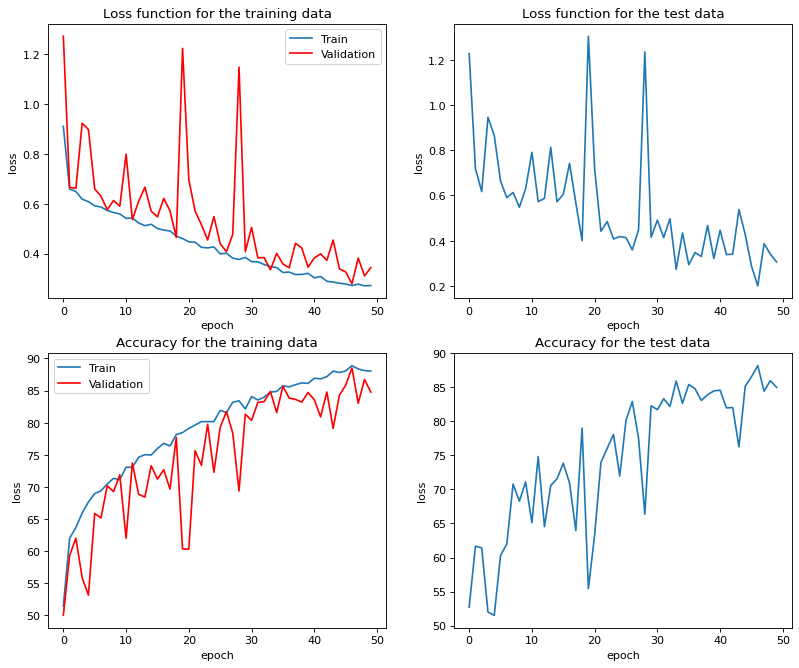

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

# with open("/content/drive/MyDrive/projectDataset/dogsAndCats/dataset/accuracy.txt", "rb") as fp:
#     d = pickle.load(fp)
#     e = pickle.load(fp)